In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

Pull in the public session and evse tables and combine on evse_id.

### session table

`session_id` - PK - an identifier that is artificially generated to represent a unique charging session

`evse_id` - FK to the EVSE table, represents the EVSE where the session is being completed

`connector_id` - FK to connector table represents which unique port is being used

`start_datetime` - session start date and time

`end_datetime` - session charge end date and time

`total_duration` - the amount of time between start_datetime and end_datetime (in hours)

`charge_duration` - the amount of time that energy was provided from the EVSE to the vehicle (in hours)

`energy_kwh` - amount of energy provided (in kWh)

`charge_level` - records which level of charging is being used for that session (L2, DCFC)

`start_soc` - % of battery capacity  at the start of the session (only available for DCFC)

`end_soc` - % of battery capacity at the end of session (only available for DCFC)

`flag_id` - FK to PK id in flag table, denotes an error with the session (refer to flag table)

### evse table

`evse_id` - PK - an identifier that is artificially generated to represent a unique EVSE

`metro_area` - The metropolitan area that the particular EVSE resides in. Undesignated are areas either not in metropolitain areas or an area with too few EVSE for anonymization

`land_use` - Identifies whether the EVSE is in a Metro area, Non-Metro area, or the location is undesignated

`region` - This is the region of the US the EVSE is located in. These are the same divisions from the US Census

`num_ports` - the number of ports capable of simultaneous charging available at a EVSE

`charge_level` - rate of charging (L2, DCFC)

`venue` - Derived field of venue type

`pricing` - Information on charging. Can be Paid, Free, or Undesignated


In [2]:
sessions_df = pd.read_csv("../data/evwatts.public.session.csv")
evse_df = pd.read_csv("../data/evwatts.public.evse.csv")

In [3]:
combined_df = pd.merge(sessions_df, evse_df, on='evse_id')
combined_df.head()

,session_id,evse_id,connector_id,start_datetime,end_datetime,total_duration,charge_duration,energy_kwh,start_soc,end_soc,flag_id,metro_area,land_use,region,num_ports,charge_level,venue,pricing
0,11562,5,5,2020-03-01 09:37:44,2020-03-01 11:14:59,1.621389,1.615556,6.170,NaN,NaN,0,Undesignated,Undesignated,Middle Atlantic,2,L2,Municipal Building,Undesignated
1,11563,116,116,2020-03-01 10:02:24,2020-03-01 11:08:14,1.096944,1.089722,5.212,NaN,NaN,0,Undesignated,Metro Area,Middle Atlantic,2,L2,Medical or Educational Campus,Undesignated
2,11564,72,72,2020-03-01 10:06:08,2020-03-01 11:08:10,1.033611,1.024722,3.392,NaN,NaN,0,"Rochester, NY Metro Area",Metro Area,Middle Atlantic,2,L2,Municipal Building,Undesignated
3,11565,1,1,2020-03-01 10:01:12,2020-03-01 11:07:09,1.099722,1.076111,6.521,NaN,NaN,0,"Albany-Schenectady-Troy, NY Metro Area",Metro Area,Middle Atlantic,2,L2,Municipal Building,Undesignated
4,11566,0,138,2020-02-29 19:09:03,2020-03-01 10:47:16,15.636667,12.658889,80.527,NaN,NaN,0,"Albany-Schenectady-Troy, NY Metro Area",Metro Area,Middle Atlantic,2,L2,Municipal Building,Undesignated


In [4]:
# Drop na function
def deal_with_na(df: pd.DataFrame) -> pd.DataFrame:
    '''Function to modularize the workings of na's'''

    # Remove undesignated rows
    df = df[df.pricing != 'Undesignated']
    df = df[df.metro_area != 'Undesignated']

    # Assume charge durations < 0 are false
    df = df[df.charge_duration >= 0]

    # Check the end_soc - start_soc
    # df = df[(df.end_soc - df.start_soc) > 0]

    return df.dropna()

def clean_date_column(df: pd.DataFrame) -> pd.DataFrame:
    '''Function to modify the date'''

    # Clean up date
    df.start_datetime = pd.to_datetime(df.start_datetime)
    df['year'] = df.start_datetime.dt.year
    df['month'] = df.start_datetime.dt.month
    df['day'] = df.start_datetime.dt.day
    df['hour'] = df.start_datetime.dt.hour
    df['day_of_year'] = df.start_datetime.dt.day_of_year
    df['quarter'] = df.start_datetime.dt.quarter
    df['weekday'] = df.start_datetime.dt.weekday
    df['week_num'] = df.start_datetime.dt.day_of_year // 7

    # Drop the original date
    df = df.drop(columns=['start_datetime'])

    return df

def change_data_types(df: pd.DataFrame) -> pd.DataFrame:
    '''Corrects data types'''

    df.num_ports = df.num_ports.astype(int)  # Can only have integer ports

    return df

# Function for cleaning
def clean_dataset(df: pd.DataFrame) -> pd.DataFrame:
    '''Function to clean dataset'''

    # Deal with NaN's
    df = deal_with_na(df)

    # Clean the date
    df = clean_date_column(df)

    # Data types
    df = change_data_types(df)

    return df

def filter_known_faults(df: pd.DataFrame) -> pd.DataFrame:
    '''Function to filter known faults'''

    known_faults = [0, 1, 2, 4, 8, 16, 32,
                    64, 128, 256, 512, 1024,
                    2048, 4096, 8192, 16384,
                    32768, 65536]

    initial_count = len(df)
    # Filter out known faults
    df = df[df.flag_id.isin(known_faults)]
    final_count = len(df)
    print(f"Rows removed based on unknown fault code: {initial_count - final_count}")

    return df

def filter_winter_months(df: pd.DataFrame) -> pd.DataFrame:
    '''Function to filter winter months'''

    initial_count = len(df)
    # Filter out nonwinter months
    df = df[df.month.isin([1, 2, 3, 4, 11, 12])]
    final_count = len(df)
    print(f"Rows removed based on winter months: {initial_count - final_count}")

    return df

def filter_nonwinter_months(df: pd.DataFrame) -> pd.DataFrame:
    '''Function to filter summer months'''

    initial_count = len(df)
    # Filter out winter months
    df = df[df.month.isin([5, 6, 7, 8, 9, 10])]
    final_count = len(df)
    print(f"Rows removed based on non-winter months: {initial_count - final_count}")

    return df

def filter_weekend(df: pd.DataFrame) -> pd.DataFrame:
    '''Function to filter weekends'''

    initial_count = len(df)
    # Filter for weekends only
    df = df[df.weekday.isin([4, 5, 6])]
    final_count = len(df)
    print(f"Rows removed based on weekends: {initial_count - final_count}")

    return df


In [5]:
combined_df = clean_dataset(combined_df)
combined_df.head()

,session_id,evse_id,connector_id,end_datetime,total_duration,charge_duration,energy_kwh,start_soc,end_soc,flag_id,...,venue,pricing,year,month,day,hour,day_of_year,quarter,weekday,week_num
136055,153092,819,1463,2020-05-29 18:43:06,0.360556,0.353333,12.057000,55.0,73.0,0,...,Corridor,Free,2020,5,29,18,150,2,4,21
136056,153093,819,1463,2020-05-29 19:12:42,0.415278,0.411111,9.063000,73.0,87.0,0,...,Corridor,Free,2020,5,29,18,150,2,4,21
136057,153094,819,1463,2019-11-14 10:57:21,0.354167,0.347778,6.170000,40.0,50.0,0,...,Corridor,Free,2019,11,14,10,318,4,3,45
136058,153095,819,1463,2020-06-26 20:56:36,0.652222,0.645278,20.837999,46.0,80.0,0,...,Corridor,Free,2020,6,26,20,178,2,4,25
136059,153096,819,1463,2020-02-24 19:10:28,1.130278,1.123333,23.757999,55.0,94.0,0,...,Corridor,Free,2020,2,24,18,55,1,0,7


## Data Exploration with Flag ID

In [ ]:
# # Set the aesthetic style of the plots
# sns.set_style("whitegrid")

# # Plot the distribution of flag_id
# plt.figure(figsize=(10, 6))
# sns.countplot(data=combined_df, x='flag_id')
# plt.title('Distribution of flag_id')
# plt.show()

# # Plot the relationship between flag_id and total_duration
# plt.figure(figsize=(10, 6))
# sns.boxplot(data=combined_df, x='flag_id', y='total_duration')
# plt.title('Total Duration vs Flag ID')
# plt.show()

# # Plot the relationship between flag_id and venue
# plt.figure(figsize=(10, 6))
# sns.boxplot(data=combined_df, x='flag_id', y='venue')
# plt.title('Venue vs Flag ID')
# plt.show()

# # Plot the relationship between flag_id and energy_kwh
# plt.figure(figsize=(10, 6))
# sns.boxplot(data=combined_df, x='flag_id', y='energy_kwh')
# plt.title('Energy (kWh) vs Flag ID')
# plt.show()

## Flag ID by Metro Area

In [7]:
def aggregate_for_map(df: pd.DataFrame, filter_by_quarter:bool=False, year:int=2019, quarter:int=1) -> pd.DataFrame:
  '''Function to aggregate data for the map'''

  metro_area_coords = {
    'Undesignated': (None, None),
    'Rochester, NY Metro Area': (43.1566, -77.6088),
    'Albany-Schenectady-Troy, NY Metro Area': (42.6526, -73.7562),
    'Dallas-Fort Worth-Arlington, TX Metro Area': (32.7767, -96.7970),
    'Denver-Aurora-Lakewood, CO Metro Area': (39.7392, -104.9903),
    'Boulder, CO Metro Area': (40.0150, -105.2705),
    'Los Angeles-Long Beach-Anaheim, CA Metro Area': (34.0522, -118.2437),
    'Des Moines-West Des Moines, IA Metro Area': (41.5868, -93.6250),
    'Boston-Cambridge-Newton, MA-NH Metro Area': (42.3601, -71.0589),
    'Providence-Warwick, RI-MA Metro Area': (41.8240, -71.4128),
    'New York-Newark-Jersey City, NY-NJ-PA Metro Area': (40.7128, -74.0060),
    'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD Metro Area': (39.9526, -75.1652),
    'Washington-Arlington-Alexandria, DC-VA-MD-WV Metro Area': (38.9072, -77.0369),
    'Baltimore-Columbia-Towson, MD Metro Area': (39.2904, -76.6122),
    'Detroit-Warren-Dearborn, MI Metro Area': (42.3314, -83.0458),
    'Austin-Round Rock-Georgetown, TX Metro Area': (30.2672, -97.7431),
    'Burlington-South Burlington, VT Metro Area': (44.4759, -73.2121),
    'Chicago-Naperville-Elgin, IL-IN-WI Metro Area': (41.8781, -87.6298),
    'Salem, OR Metro Area': (44.9429, -123.0351),
    'Seattle-Tacoma-Bellevue, WA Metro Area': (47.6062, -122.3321),
    'Las Vegas-Henderson-Paradise, NV Metro Area': (36.1699, -115.1398),
    'Phoenix-Mesa-Chandler, AZ Metro Area': (33.4484, -112.0740),
    'Miami-Fort Lauderdale-Pompano Beach, FL Metro Area': (25.7617, -80.1918),
    'Ann Arbor, MI Metro Area': (42.2808, -83.7430),
    'Kansas City, MO-KS Metro Area': (39.0997, -94.5786),
    'Grand Rapids-Kentwood, MI Metro Area': (42.9634, -85.6681),
    'Pittsburgh, PA Metro Area': (40.4406, -79.9959),
    'Portland-Vancouver-Hillsboro, OR-WA Metro Area': (45.5051, -122.6750),
    'Reno, NV Metro Area': (39.5296, -119.8138),
    'Worcester, MA-CT Metro Area': (42.2626, -71.8023)
  }

  if filter_by_quarter:
    # Filter data by quarter and year
    df = df[(df['year'] == year) & (df['quarter'] == quarter)]

  # Aggregate data by metro_area
  agg_df = df.groupby('metro_area').agg(
    flag_id_0_count=pd.NamedAgg(column='flag_id', aggfunc=lambda x: (x == 0).sum()),
    flag_id_non_0_count=pd.NamedAgg(column='flag_id', aggfunc=lambda x: (x != 0).sum())
  ).reset_index()

  # Map metro areas to coordinates
  agg_df['latitude'] = agg_df['metro_area'].map(lambda x: metro_area_coords.get(x, (None, None))[0])
  agg_df['longitude'] = agg_df['metro_area'].map(lambda x: metro_area_coords.get(x, (None, None))[1])

  # Calculate percentage of non-0 flag_id
  agg_df['flag_id_ftld_per'] = round(agg_df['flag_id_non_0_count'] / (agg_df['flag_id_0_count'] + agg_df['flag_id_non_0_count']), 2)

  return agg_df

In [8]:
from vega_datasets import data

states = alt.topo_feature(data.us_10m.url, feature="states")

def display_map(df: pd.DataFrame, title, states=states) -> alt.Chart:
    background = alt.Chart(states).mark_geoshape(
        fill="#e3faff",
        stroke="#bbbcbd"
    ).properties(
        width=750,
        height=500
    ).project("albersUsa")

    points_flag_id_0 = alt.Chart(df).mark_circle().encode(
        latitude="latitude:Q",
        longitude="longitude:Q",
        size=alt.Size("flag_id_0_count:Q").legend(None).scale(range=[0, 5000]),
        color=alt.value("#51fafc"),
        tooltip=["metro_area:N", "flag_id_0_count:Q", alt.Tooltip("flag_id_ftld_per:Q", format=".0%")]
    )

    points_flag_id_non_0 = alt.Chart(df).mark_circle().encode(
        latitude="latitude:Q",
        longitude="longitude:Q",
        size=alt.Size("flag_id_non_0_count:Q").legend(None).scale(range=[0, 5000]),
        color=alt.value("#5f51fc"),
        tooltip=["metro_area:N", "flag_id_non_0_count:Q", alt.Tooltip("flag_id_ftld_per:Q", format=".0%")]
    )

    legend = alt.Chart(pd.DataFrame({
        'Color': ['#51fafc', '#5f51fc'],
        'Label': ['No Faults (flag_id == 0)', 'Faulted (flag_id != 0)']
    })).mark_point().encode(
        y=alt.Y('Label:N', axis=alt.Axis(title='')),
        color=alt.Color('Color:N', scale=None)
    )

    return (background + points_flag_id_0 + points_flag_id_non_0 | legend).configure_view(stroke=None).properties(
        title=f"Faulted vs Non-Faulted Charging Sessions by Metro Area ({title})"
    )

In [9]:
display_map(aggregate_for_map(combined_df), "No Filter")

alt.HConcatChart(...)

In [11]:
combined_df_known_faults = filter_known_faults(combined_df)

Rows removed based on unknown fault code: 12965


In [48]:
display_map(aggregate_for_map(combined_df_known_faults), "Filter For Known Faults Only")

alt.HConcatChart(...)

In [52]:
display_map(aggregate_for_map(filter_winter_months(combined_df_known_faults)), "Filter For Winter Months Only")

Rows removed based on winter months: 511868


alt.HConcatChart(...)

In [49]:
display_map(aggregate_for_map(filter_nonwinter_months(combined_df_known_faults)), "Filter For Non-Winter Months Only")

Rows removed based on non-winter months: 488218


alt.HConcatChart(...)

In [51]:
display_map(aggregate_for_map(filter_weekend(combined_df_known_faults)), "Filter For Weekends Only")

Rows removed based on weekends: 580765


alt.HConcatChart(...)

In [15]:
import os

years = sorted([int(x) for x in list(combined_df_known_faults.year.unique())])
quarters = range(1, 5)

for year in years:
    for quarter in quarters:
        chart = display_map(aggregate_for_map(combined_df_known_faults, True, year, quarter), f"Quarter {quarter} of {year}")
        # Create the maps directory if it doesn't exist
        if not os.path.exists("maps"):
            os.makedirs("maps")

        chart.save(f"maps/map_{year}_Q{quarter}.png")

In [20]:
import imageio.v2 as imageio
import os
import re

# Specify the directory containing your PNG images
image_dir = "./maps"

# List all PNG files in the directory
images = []
files = os.listdir(image_dir)
files = sorted(files, key=lambda x: (int(re.search(r'(\d{4})', x).group()), int(re.search(r'Q(\d)', x).group(1))))
for file_name in files:
    if file_name.endswith('.png'):
        file_path = os.path.join(image_dir, file_name)
        images.append(imageio.imread(file_path))

# Save the images as a GIF
output_path = "animation.gif"
imageio.mimsave(output_path, images, fps=1, loop=0)  # Increase the duration and set loop to 0 for infinite loop
print(f"Animation saved as {output_path}")

Animation saved as animation.gif


/var/folders/l2/s8ytcc311f791rmypblvt8l40000gn/T/ipykernel_51052/3290638443.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Year')


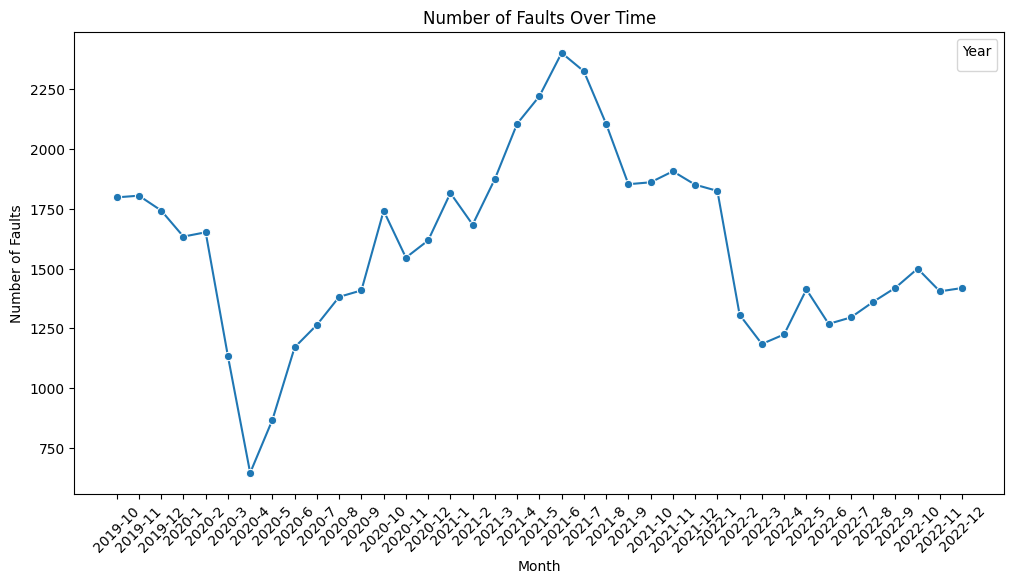

In [23]:
# Group by year and month and count the number of faults
faults_over_time = combined_df_known_faults[combined_df_known_faults.flag_id != 0].groupby(['year', 'month']).flag_id.count().reset_index()

# Rename columns for clarity
faults_over_time.columns = ['Year', 'Month', 'Number of Faults']

# Plot the data
plt.figure(figsize=(12, 6))
# Create a new column for Year-Month
faults_over_time['Year-Month'] = faults_over_time['Year'].astype(str) + '-' + faults_over_time['Month'].astype(str)

# Plot the data
sns.lineplot(data=faults_over_time, x='Year-Month', y='Number of Faults', marker='o')
plt.xticks(rotation=45)
plt.title('Number of Faults Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Faults')
plt.legend(title='Year')
plt.show()

/var/folders/l2/s8ytcc311f791rmypblvt8l40000gn/T/ipykernel_51052/692073081.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Year')


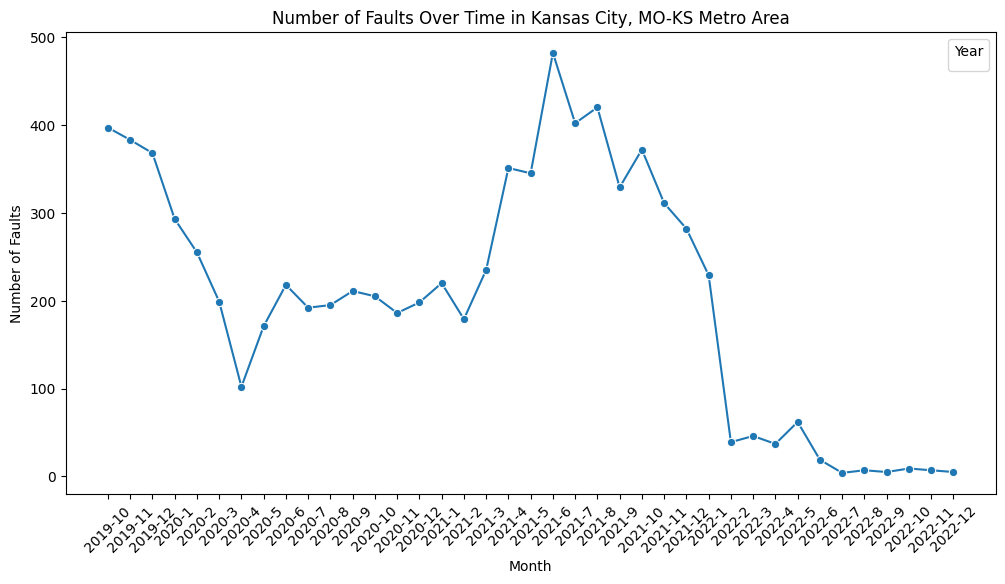

In [24]:
# Group by year and month and count the number of faults
faults_over_time = combined_df_known_faults[(combined_df_known_faults.flag_id != 0) & (combined_df_known_faults.metro_area == 'Kansas City, MO-KS Metro Area')].groupby(['year', 'month']).flag_id.count().reset_index()

# Rename columns for clarity
faults_over_time.columns = ['Year', 'Month', 'Number of Faults']

# Plot the data
plt.figure(figsize=(12, 6))
# Create a new column for Year-Month
faults_over_time['Year-Month'] = faults_over_time['Year'].astype(str) + '-' + faults_over_time['Month'].astype(str)

# Plot the data
sns.lineplot(data=faults_over_time, x='Year-Month', y='Number of Faults', marker='o')
plt.xticks(rotation=45)
plt.title('Number of Faults Over Time in Kansas City, MO-KS Metro Area')
plt.xlabel('Month')
plt.ylabel('Number of Faults')
plt.legend(title='Year')
plt.show()

In [ ]:

# check data by time period


# ways to do anomaly detection for the data
# failure analysis
# the document for ethical issues